In [1]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

In [60]:
#import statements
from torch_geometric.data import InMemoryDataset, Data
from torch_cluster import knn_graph
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.data import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_max_pool
import matplotlib.pyplot as plt
import torch.nn.functional as F
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# reads and returns the data from google drive  
def readData(filename, dtype=float):
    def openFile():
        with open(filename, 'r') as f:
            for line in f:
                line = line.rstrip().split(',')
                for elm in line:
                    yield dtype(elm)
        readData.length = len(line)

    d = np.fromiter(openFile(), dtype=dtype)
    d = d.reshape((-1, readData.length))
    return d

data = readData('/content/gdrive/My Drive/best2ndData5k4Classes.csv')
labels = readData('/content/gdrive/My Drive/best2ndLabels5k4Classes.csv')

print(labels.shape)

all_data = data.reshape(-1, 5000, 3)
print(all_data.shape)

(385, 1)
(385, 5000, 3)


In [5]:
#maps between class labels and actual class
CLASS_MAP = {
    'vans': 0,
    'cars': 1,
    'people': 2,
    'bic': 3
}

In [6]:
#wrapper class PointData to work pytorch geometric
#edit the class to work with our data 

class PointData(InMemoryDataset):
    def __init__(self, data_list):
        self.data_list = data_list
        super(PointData, self).__init__("", None, None)
        self.data = self._data
        self.slices = self._slices

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return []

    @property
    def num_classes(self):
        return 4

    def process(self):
      # Read data into huge `Data` list.
      data_list = self.data_list

      if self.pre_filter is not None:
          data_list = [data for data in data_list if self.pre_filter(data)]

      data, slices = self.collate(data_list)
      self._data = data
      self._slices = slices

data_list = []
for item, label in zip(all_data, labels):
  data_list.append(Data(pos=torch.tensor(item).float(), y=torch.tensor(label).long()))

dataset = PointData(data_list)

print(dataset[0].y)
print(dataset[150].y)

Processing...
Done!
tensor([0])
tensor([1])


In [80]:
# defined pointnet layers which will be used in pytorch geometric 
class pointLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # super(pointLayer, self).__init__('add')
        super(pointLayer, self).__init__('max') 

        self.input_layer = in_channels + 3
        self.hidden_layer_one = int((in_channels + 3 + out_channels)/2)
        self.hidden_layer_two = int((self.hidden_layer_one + out_channels)/2)
        self.outputer_layer = out_channels

        self.mlp = Sequential(Linear(self.input_layer, self.hidden_layer_one),
                              ReLU(),
                              Linear(self.hidden_layer_one, self.hidden_layer_two),
                              Linear(self.hidden_layer_two, self.outputer_layer))
        
    def forward(self, x, position, edge_index):
        # print(x)
        return self.propagate(edge_index, h=x, pos=position)
    
    def message(self, h_j, p_j, p_i):  
        if h_j is not None:
          param = p_j - p_i
          combined = torch.cat([h_j, param], dim=-1)
        else:
          return self.mlp(p_j - p_i)

        return self.mlp(combined)  

#pointnet model  
class PointNetPlusPlus(torch.nn.Module):
    def __init__(self):
        super(PointNetPlusPlus, self).__init__()
        self.pointnetlayer1 = pointLayer(3, 32)
        self.pointnetlayer2 = pointLayer(32, 64)
        self.pointnetlayer3 = pointLayer(64, 128)
        self.fc = Linear(128, 4)
        
    def forward(self, position, batch):
        knn_k_values = 16
        edge_index = knn_graph(position, k=knn_k_values, batch=batch, loop=True)
        x = self.pointnetlayer1(position, position, edge_index)
        x = x.relu()
        x = self.pointnetlayer2(x, position, edge_index)
        x = x.relu()
        x = self.pointnetlayer3(x, position, edge_index)
        x = x.relu()
        x = global_max_pool(x, batch)  
        
        return self.fc(x)

In [12]:
#randomly get 200 points
indices = list(range(384))
np.random.shuffle(indices)

train_indices = indices[:200]
test_indices = indices[200:]

train_dataset = dataset[train_indices]
test_dataset = dataset[test_indices]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [48]:
#initalize train and testing functions

criterion = torch.nn.CrossEntropyLoss() 

def train(model, optimizer, loader):
    model.train()
    agr_loss = 0
    for data in loader:
        optimizer.zero_grad()  
        res = model(data.pos, data.batch) 
        loss = criterion(res, data.y)  
        loss.backward() 
        optimizer.step()  
        agr_loss += loss.item() * data.num_graphs

    return agr_loss / len(train_loader.dataset)

@torch.no_grad()
def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        res = model(data.pos, data.batch)
        guess = res.argmax(dim=-1)
        correct += int((guess == data.y).sum())
    return correct / 184

In [74]:
#run model for 100 epochs

model = PointNetPlusPlus()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss() 

test_accuries = []

for epoch in range(1, 100):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    test_accuries.append(test_acc)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 01, Loss: 1.3969, Test Accuracy: 0.2880
Epoch: 02, Loss: 1.3661, Test Accuracy: 0.3967
Epoch: 03, Loss: 1.3362, Test Accuracy: 0.4620
Epoch: 04, Loss: 1.3033, Test Accuracy: 0.4293
Epoch: 05, Loss: 1.2560, Test Accuracy: 0.4565
Epoch: 06, Loss: 1.1966, Test Accuracy: 0.5870
Epoch: 07, Loss: 1.1193, Test Accuracy: 0.6196
Epoch: 08, Loss: 1.0443, Test Accuracy: 0.5272
Epoch: 09, Loss: 0.9753, Test Accuracy: 0.5543
Epoch: 10, Loss: 0.9404, Test Accuracy: 0.6250
Epoch: 11, Loss: 0.8876, Test Accuracy: 0.5272
Epoch: 12, Loss: 0.8662, Test Accuracy: 0.6250
Epoch: 13, Loss: 0.8252, Test Accuracy: 0.6196
Epoch: 14, Loss: 0.8020, Test Accuracy: 0.6250
Epoch: 15, Loss: 0.7767, Test Accuracy: 0.6902
Epoch: 16, Loss: 0.7624, Test Accuracy: 0.6467
Epoch: 17, Loss: 0.7493, Test Accuracy: 0.6196
Epoch: 18, Loss: 0.7336, Test Accuracy: 0.6250
Epoch: 19, Loss: 0.7232, Test Accuracy: 0.7065
Epoch: 20, Loss: 0.6883, Test Accuracy: 0.6630
Epoch: 21, Loss: 0.6710, Test Accuracy: 0.6467
Epoch: 22, Lo

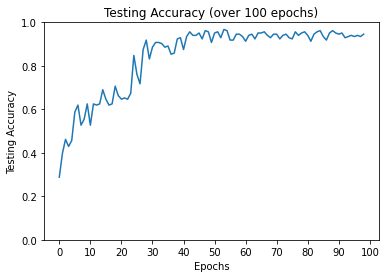

In [79]:
#plot 100 epochs 

plt.plot(test_accuries)
plt.title("Testing Accuracy (over 100 epochs)")
plt.xlabel("Epochs")
plt.ylabel("Testing Accuracy")
plt.ylim((0, 1))
plt.xticks(np.arange(0,110,10))
plt.show()

In [84]:
# print accuries over 100 epochs
np.array(test_accuries)

array([0.28804348, 0.39673913, 0.46195652, 0.42934783, 0.45652174,
       0.58695652, 0.61956522, 0.52717391, 0.55434783, 0.625     ,
       0.52717391, 0.625     , 0.61956522, 0.625     , 0.69021739,
       0.64673913, 0.61956522, 0.625     , 0.70652174, 0.66304348,
       0.64673913, 0.65217391, 0.64673913, 0.67391304, 0.84782609,
       0.76086957, 0.7173913 , 0.875     , 0.91847826, 0.83152174,
       0.88586957, 0.9076087 , 0.9076087 , 0.90217391, 0.88586957,
       0.89130435, 0.85326087, 0.85869565, 0.92391304, 0.92934783,
       0.875     , 0.93478261, 0.95652174, 0.94021739, 0.94021739,
       0.95108696, 0.92391304, 0.96195652, 0.95652174, 0.9076087 ,
       0.95108696, 0.95652174, 0.92934783, 0.9673913 , 0.96195652,
       0.91847826, 0.91847826, 0.94565217, 0.94565217, 0.93478261,
       0.91304348, 0.94021739, 0.94565217, 0.92391304, 0.95108696,
       0.95108696, 0.95652174, 0.94021739, 0.92934783, 0.94565217,
       0.94565217, 0.92391304, 0.94021739, 0.94565217, 0.92934

In [85]:
# get guesses 
guesses = [0] * 184
outside = 0
for data in test_loader:
  allPred = model(data.pos, data.batch)
  onePred = allPred.argmax(dim=-1)
  gues = onePred.cpu().detach().tolist()
  for g in gues:
    guesses[outside] = g
    outside += 1

In [86]:
# get correct answers 
correct = [0] * 184
outside = 0
for data in test_loader:
  cor = data.y.cpu().detach().tolist()
  for c in cor:
    correct[outside] = c
    outside += 1

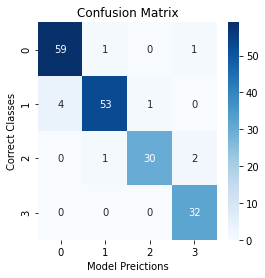

In [87]:
# generate confusion matrix
def generateConfusionMatrix(correct, guess):
  matrix = tf.math.confusion_matrix(correct, guess)
  fig, ax = plt.subplots(figsize=(4,4))         # Sample figsize in inches
  sns.heatmap(matrix, annot=True, cmap='Blues', xticklabels=CLASS_MAP.values(), yticklabels=CLASS_MAP.values())
  ax.set_xlabel("Model Preictions")
  ax.set_ylabel("Correct Classes")
  ax.set_title("Confusion Matrix")
  plt.show()
generateConfusionMatrix(correct, guesses)

In [30]:
# testing different knn k values
model = PointNetPlusPlus()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs_run_for = 15

for epoch in range(1, epochs_run_for+1):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 01, Loss: 1.2941, Test Accuracy: 0.6413
Epoch: 02, Loss: 0.9985, Test Accuracy: 0.6359
Epoch: 03, Loss: 0.8842, Test Accuracy: 0.6576
Epoch: 04, Loss: 0.8244, Test Accuracy: 0.5217
Epoch: 05, Loss: 0.7481, Test Accuracy: 0.6793
Epoch: 06, Loss: 0.6845, Test Accuracy: 0.6413
Epoch: 07, Loss: 0.6356, Test Accuracy: 0.6630
Epoch: 08, Loss: 0.6106, Test Accuracy: 0.8315
Epoch: 09, Loss: 0.5389, Test Accuracy: 0.7500
Epoch: 10, Loss: 0.5018, Test Accuracy: 0.7935
Epoch: 11, Loss: 0.4704, Test Accuracy: 0.7989
Epoch: 12, Loss: 0.4515, Test Accuracy: 0.9076
Epoch: 13, Loss: 0.4525, Test Accuracy: 0.8967
Epoch: 14, Loss: 0.4115, Test Accuracy: 0.6685
Epoch: 15, Loss: 0.4220, Test Accuracy: 0.9293


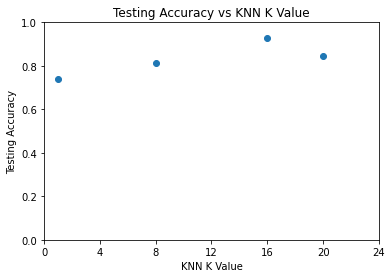

In [34]:
#collected testing accuries for dirrect knn_k_values from above
#ran for 10 epochs
knn_k_values = [1,8,16,20]
final_test_accuries = [0.7413, .8112, .9293, .8465]

plt.scatter(knn_k_values, final_test_accuries)
plt.title("Testing Accuracy vs KNN K Value")
plt.xlabel("KNN K Value")
plt.ylabel("Testing Accuracy")
plt.ylim((0, 1))
plt.xticks(np.arange(0,26,4))
plt.show()

In [14]:
# testing different learning rate values
model = PointNetPlusPlus()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 15):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 01, Loss: 1.2922, Test Accuracy: 0.5924
Epoch: 02, Loss: 1.0389, Test Accuracy: 0.6250
Epoch: 03, Loss: 0.8474, Test Accuracy: 0.4946
Epoch: 04, Loss: 0.8150, Test Accuracy: 0.6304
Epoch: 05, Loss: 0.7693, Test Accuracy: 0.6739
Epoch: 06, Loss: 0.6686, Test Accuracy: 0.5543
Epoch: 07, Loss: 0.6249, Test Accuracy: 0.8207
Epoch: 08, Loss: 0.5264, Test Accuracy: 0.8804
Epoch: 09, Loss: 0.4562, Test Accuracy: 0.6196
Epoch: 10, Loss: 0.5840, Test Accuracy: 0.7717
Epoch: 11, Loss: 0.5121, Test Accuracy: 0.8804
Epoch: 12, Loss: 0.4303, Test Accuracy: 0.9076
Epoch: 13, Loss: 0.3672, Test Accuracy: 0.8533
Epoch: 14, Loss: 0.3492, Test Accuracy: 0.9293


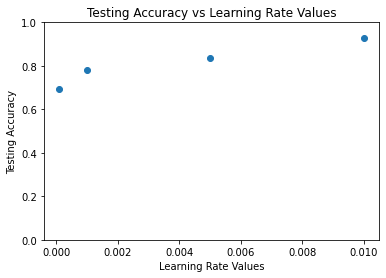

In [26]:
#collected testing accuries for dirrect learning rate values from above
#ran for 10 epochs
lr_vals = [0.0001,0.001,0.005, 0.01]
final_test_accuries = [.6916, .7832, .8341, .9293]

plt.scatter(x=lr_vals, y=final_test_accuries)
plt.title("Testing Accuracy vs Learning Rate Values")
plt.xlabel("Learning Rate Values")
plt.ylabel("Testing Accuracy")
plt.ylim((0, 1))
plt.xticks(np.arange(0,0.01 + .002, .002))
plt.show()

In [42]:
#Test different optimizers 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

model = PointNetPlusPlus()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

for epoch in range(1, 15):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 01, Loss: 1.3239, Test Accuracy: 0.3478
Epoch: 02, Loss: 1.1327, Test Accuracy: 0.4457
Epoch: 03, Loss: 1.0653, Test Accuracy: 0.5054
Epoch: 04, Loss: 0.9506, Test Accuracy: 0.5054
Epoch: 05, Loss: 0.9262, Test Accuracy: 0.6250
Epoch: 06, Loss: 0.8532, Test Accuracy: 0.5870
Epoch: 07, Loss: 0.8234, Test Accuracy: 0.6902
Epoch: 08, Loss: 0.8044, Test Accuracy: 0.6793
Epoch: 09, Loss: 0.7673, Test Accuracy: 0.7065
Epoch: 10, Loss: 0.7384, Test Accuracy: 0.6413
Epoch: 11, Loss: 0.7431, Test Accuracy: 0.5761
Epoch: 12, Loss: 0.7312, Test Accuracy: 0.7337
Epoch: 13, Loss: 0.6870, Test Accuracy: 0.7391
Epoch: 14, Loss: 0.6842, Test Accuracy: 0.7391


In [43]:
optimizerLabel = ["Adam", "RMSprop", "SGD"]
optimizer_accuracy = [.9213, 0.7391, .5912]

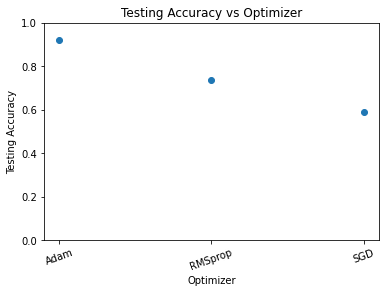

In [82]:
plt.scatter(x=[0,1,2], y=optimizer_accuracy)
plt.title("Testing Accuracy vs Optimizer")
plt.xlabel("Optimizer")
plt.ylabel("Testing Accuracy")
plt.xticks([0, 1, 2], ['Adam', 'RMSprop', 'SGD'], rotation=20)
plt.ylim((0, 1))
plt.show()

In [50]:
#Test new architecture out for the model
model = PointNetPlusPlus()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 30):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 01, Loss: 1.3750, Test Accuracy: 0.4891
Epoch: 02, Loss: 1.3496, Test Accuracy: 0.3750
Epoch: 03, Loss: 1.3227, Test Accuracy: 0.4511
Epoch: 04, Loss: 1.2859, Test Accuracy: 0.6196
Epoch: 05, Loss: 1.2366, Test Accuracy: 0.6196
Epoch: 06, Loss: 1.1749, Test Accuracy: 0.5380
Epoch: 07, Loss: 1.1060, Test Accuracy: 0.6250
Epoch: 08, Loss: 1.0435, Test Accuracy: 0.6250
Epoch: 09, Loss: 0.9813, Test Accuracy: 0.6141
Epoch: 10, Loss: 0.9301, Test Accuracy: 0.6250
Epoch: 11, Loss: 0.8825, Test Accuracy: 0.6304
Epoch: 12, Loss: 0.8420, Test Accuracy: 0.6304
Epoch: 13, Loss: 0.8184, Test Accuracy: 0.5707
Epoch: 14, Loss: 0.7976, Test Accuracy: 0.6359
Epoch: 15, Loss: 0.7652, Test Accuracy: 0.6304
Epoch: 16, Loss: 0.7354, Test Accuracy: 0.6359
Epoch: 17, Loss: 0.7242, Test Accuracy: 0.6848
Epoch: 18, Loss: 0.6981, Test Accuracy: 0.7065
Epoch: 19, Loss: 0.6694, Test Accuracy: 0.8587
Epoch: 20, Loss: 0.6719, Test Accuracy: 0.8478
Epoch: 21, Loss: 0.6418, Test Accuracy: 0.7120
Epoch: 22, Lo

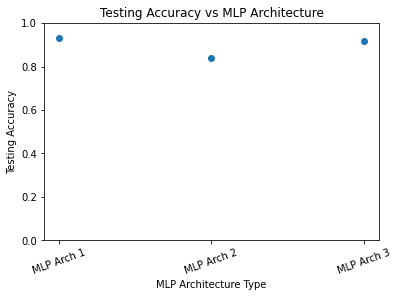

In [73]:
arch_accuracy = [0.9293,0.8370,0.9154]
plt.scatter(x=[0,1,2], y=arch_accuracy)
plt.title("Testing Accuracy vs MLP Architecture")
plt.xlabel("MLP Architecture Type")
plt.ylabel("Testing Accuracy")
plt.xticks([0, 1, 2], ["MLP Arch 1", "MLP Arch 2", "MLP Arch 3"], rotation=20)
plt.ylim((0, 1))
plt.show()

In [63]:
#table with all the data
experiment_name = ["KNN K Value", "KNN K Value", "KNN K Value", "KNN K Value", 
                   "Learning Rate", "Learning Rate", "Learning Rate", "Learning Rate",
                   "Optimizer", "Optimizer", "Optimizer", "MLP Architecture", "MLP Architecture", "MLP Architecture"]
valTested = [1,4,8,16,0.0001,0.001,0.005,0.01, "ADAM", "RMSprop", "SGD", "MLP Arch 1", "MLP Arch 2", "MLP Arch 3"]
result_accuracy = [0.7413, .8112, .9293, .8465,.6916, .7832, .8341, .9293,.9213, 0.7391, .5912,0.9293,0.8370,0.9154]

d = {'Experiment': experiment_name, 'Value Tested': valTested, 'Accuracy': result_accuracy}
df = pd.DataFrame(data=d)
df

,Experiment,Value Tested,Accuracy
0,KNN K Value,1,0.7413
1,KNN K Value,4,0.8112
2,KNN K Value,8,0.9293
3,KNN K Value,16,0.8465
4,Learning Rate,0.0001,0.6916
5,Learning Rate,0.001,0.7832
6,Learning Rate,0.005,0.8341
7,Learning Rate,0.01,0.9293
8,Optimizer,ADAM,0.9213
9,Optimizer,RMSprop,0.7391
